# Final Machine Unlearning Notebook

This notebook contains the complete implementation for machine unlearning experiments.

## Imports

### Import Required Libraries

Import all necessary libraries for:
- **NumPy & Pandas**: Data manipulation and array operations
- **PyTorch**: Neural network framework
- **Matplotlib & Seaborn**: Data visualization
- **Scikit-learn**: Train/test split and evaluation metrics
- **tqdm**: Progress bars for training loops

In [22]:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
from tqdm import tqdm
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.metrics import Metric
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import time

### Generate the Spiral Dataset

This cell generates a synthetic multi-class spirals dataset. Here's how it works:

#### Dataset Characteristics:
- **4 classes**: Each representing a different spiral arm
- **300 samples per class**: Total of 1200 data points
- **2D features**: X and Y coordinates in a plane

#### Mathematical Generation Process:

For each class (spiral arm):

1. **Generate theta values**: `theta = sqrt(random) * 2π`
   - Random values are square-rooted to get more uniform distribution along the spiral
   - Multiplied by 2π to create approximately 1 full rotation

2. **Calculate angle offset**: Each spiral is rotated by `(2π * class_index) / 4`
   - Class 0: 0° rotation
   - Class 1: 90° rotation
   - Class 2: 180° rotation
   - Class 3: 270° rotation
   - This spreads the spirals evenly around the origin

3. **Generate spiral radius**: `r = 2 * theta + π`
   - Creates an Archimedean spiral (constant spacing between turns)
   - The radius grows linearly with the angle

4. **Convert to Cartesian coordinates**:
   - `x = cos(theta + angle_offset) * r`
   - `y = sin(theta + angle_offset) * r`
   - This creates the spiral shape in 2D space

5. **Add Gaussian noise**: `data + N(0, 0.5²)`
   - Adds random noise with standard deviation 0.5
   - Makes the classification problem more realistic and challenging
   - Creates some overlap between classes

6. **Shuffle the data**: Randomly reorder all points
   - Ensures no ordering bias during training

#### Why Spirals?
- **Non-linearly separable**: Cannot be separated by straight lines
- **Complex decision boundaries**: Requires neural networks to learn curved boundaries
- **Ideal for testing**: Perfect for evaluating machine learning and unlearning algorithms
- **Visually interpretable**: Easy to visualize and understand the results

The generated data is stored in the `res` variable as a numpy array with shape (1200, 3), where:
- Column 0: X coordinate
- Column 1: Y coordinate
- Column 2: Class label (0, 1, 2, or 3)

In [2]:
# Set random seed for reproducibility, always 42!!
rng = np.random.default_rng(42)
torch.manual_seed(42)

# Generate multi-class spirals dataset
N = 300  # Samples per class
num_classes = 4  # Number of spiral classes

all_data = []

for class_idx in range(num_classes):
    # Generate theta values
    theta = np.sqrt(rng.random(N)) * 2 * pi
    
    # Calculate the angle offset for this spiral
    angle_offset = (2 * pi * class_idx) / num_classes
    
    # Generate spiral with rotation
    r = 2 * theta + pi
    
    # Apply rotation to spread spirals evenly
    x = np.cos(theta + angle_offset) * r
    y = np.sin(theta + angle_offset) * r
    
    # Stack coordinates
    data = np.array([x, y]).T
    
    # Add noise using modern generator API
    data = data + rng.standard_normal((N, 2)) * 0.5
    
    # Add labels
    labeled_data = np.append(data, np.full((N, 1), class_idx), axis=1)
    all_data.append(labeled_data)

# Combine all classes
res = np.vstack(all_data)
rng.shuffle(res)  # Use generator's shuffle method

print(f"Dataset shape: {res.shape}")
print(f"Total samples: {len(res)}")
print(f"Number of classes: {num_classes}")
for i in range(num_classes):
    print(f"Class {i} samples: {np.sum(res[:, 2] == i)}")

Dataset shape: (1200, 3)
Total samples: 1200
Number of classes: 4
Class 0 samples: 300
Class 1 samples: 300
Class 2 samples: 300
Class 3 samples: 300


### Visualize the Generated Dataset

Display the complete spiral dataset immediately after generation:
- Shows all 1200 points
- Each class in a different color
- Demonstrates the non-linear, complex decision boundaries

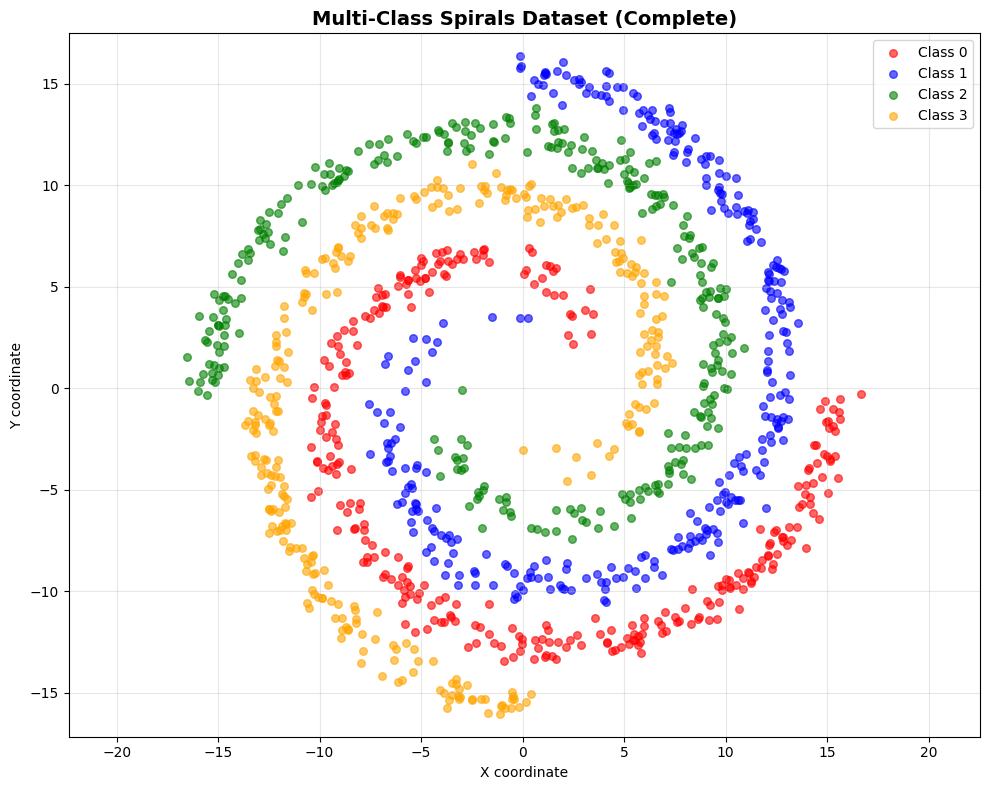

In [3]:
# Visualize the complete dataset
plt.figure(figsize=(10, 8))
colors = ['red', 'blue', 'green', 'orange']

for class_idx in range(num_classes):
    class_data = res[res[:, 2] == class_idx]
    plt.scatter(class_data[:, 0], class_data[:, 1], 
                c=colors[class_idx], label=f'Class {class_idx}',
                alpha=0.6, s=30)

plt.title('Multi-Class Spirals Dataset (Complete)', fontsize=14, fontweight='bold')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()

## Data Preparation for Training

### Load and Inspect the Dataset

This cell takes the generated spiral dataset and prepares it for training:
- Extracts features (X) and labels (y)
- Determines the number of classes
- Displays dataset information including shapes and feature ranges

In [4]:
# Use the generated spiral dataset from the previous cell
data = res

# Extract features and labels
X = data[:, :2]  # Features (x, y coordinates)
y = data[:, 2]   # Labels (class)

# Get number of classes
num_classes = int(y.max() + 1)

print(f"Dataset information:")
print(f"  Features shape: {X.shape}")
print(f"  Labels shape: {y.shape}")
print(f"  Number of classes: {num_classes}")
print(f"  Feature range - X: [{X[:, 0].min():.2f}, {X[:, 0].max():.2f}], Y: [{X[:, 1].min():.2f}, {X[:, 1].max():.2f}]")

Dataset information:
  Features shape: (1200, 2)
  Labels shape: (1200,)
  Number of classes: 4
  Feature range - X: [-16.52, 16.68], Y: [-16.07, 16.38]


### Split Data into Training and Test Sets

Split the dataset using an 80-20 ratio:
- **80% for training**: Used to train the neural network
- **20% for testing**: Used to evaluate model performance
- Uses stratified split to maintain class distribution in both sets

In [5]:
# Split the data into training and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Ensures equal class distribution in train and test
)

print(f"Training set size: {len(X_train)} samples")
print(f"Test set size: {len(X_test)} samples")
print(f"\nClass distribution in training set:")
for i in range(num_classes):
    count = np.sum(y_train == i)
    print(f"  Class {i}: {count} samples ({count/len(y_train)*100:.1f}%)")
print(f"\nClass distribution in test set:")
for i in range(num_classes):
    count = np.sum(y_test == i)
    print(f"  Class {i}: {count} samples ({count/len(y_test)*100:.1f}%)")

Training set size: 960 samples
Test set size: 240 samples

Class distribution in training set:
  Class 0: 240 samples (25.0%)
  Class 1: 240 samples (25.0%)
  Class 2: 240 samples (25.0%)
  Class 3: 240 samples (25.0%)

Class distribution in test set:
  Class 0: 60 samples (25.0%)
  Class 1: 60 samples (25.0%)
  Class 2: 60 samples (25.0%)
  Class 3: 60 samples (25.0%)


### Visualize Train/Test Split

Create a visualization showing the data split:
- Training data points (larger, filled markers)
- Test data points (smaller markers with borders)
- Different colors for each class
- Helps verify the split maintains the spiral structure

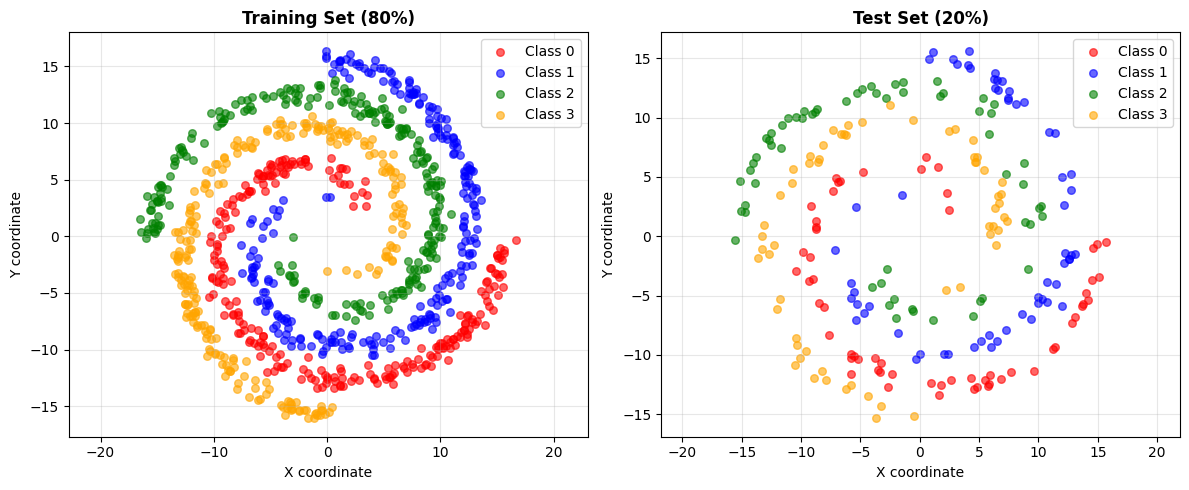

Training samples: 960
Test samples: 240


In [6]:
# Visualize the train/test split
plt.figure(figsize=(12, 5))
colors = ['red', 'blue', 'green', 'orange']

# Plot 1: Training data
plt.subplot(1, 2, 1)
for class_idx in range(num_classes):
    class_mask = y_train == class_idx
    plt.scatter(X_train[class_mask, 0], X_train[class_mask, 1],
                c=colors[class_idx], label=f'Class {class_idx}',
                alpha=0.6, s=30)
plt.title('Training Set (80%)', fontsize=12, fontweight='bold')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')

# Plot 2: Test data
plt.subplot(1, 2, 2)
for class_idx in range(num_classes):
    class_mask = y_test == class_idx
    plt.scatter(X_test[class_mask, 0], X_test[class_mask, 1],
                c=colors[class_idx], label=f'Class {class_idx}',
                alpha=0.6, s=30)
plt.title('Test Set (20%)', fontsize=12, fontweight='bold')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')

plt.tight_layout()
plt.show()

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

### Standardize the Features

Normalize the features to have zero mean and unit variance:
- Improves neural network training convergence
- Prevents features with larger scales from dominating
- Uses training set statistics to transform both train and test sets

In [7]:
# Standardize features (zero mean, unit variance)
# Important: Fit scaler only on training data to prevent data leakage

# Calculate mean and std from training data
train_mean = X_train.mean(axis=0)
train_std = X_train.std(axis=0)

print(f"Training data statistics:")
print(f"  Mean: {train_mean}")
print(f"  Std: {train_std}")

# Apply standardization to both train and test sets
X_train_scaled = (X_train - train_mean) / train_std
X_test_scaled = (X_test - train_mean) / train_std

print(f"\nAfter scaling:")
print(f"  Train mean: {X_train_scaled.mean(axis=0)}")
print(f"  Train std: {X_train_scaled.std(axis=0)}")
print(f"  Test mean: {X_test_scaled.mean(axis=0)}")
print(f"  Test std: {X_test_scaled.std(axis=0)}")

Training data statistics:
  Mean: [ 0.26551216 -0.08844693]
  Std: [8.38323429 8.3297269 ]

After scaling:
  Train mean: [5.97901358e-17 1.64220489e-17]
  Train std: [1. 1.]
  Test mean: [-0.03155592  0.04156343]
  Test std: [0.9969339  1.01151222]


### Visualize Normalized Data

Display the standardized (normalized) dataset:
- Shows how the data looks after standardization
- Features now have zero mean and unit variance
- The shape and relationships are preserved, just rescaled
- This is what the neural network will actually see during training

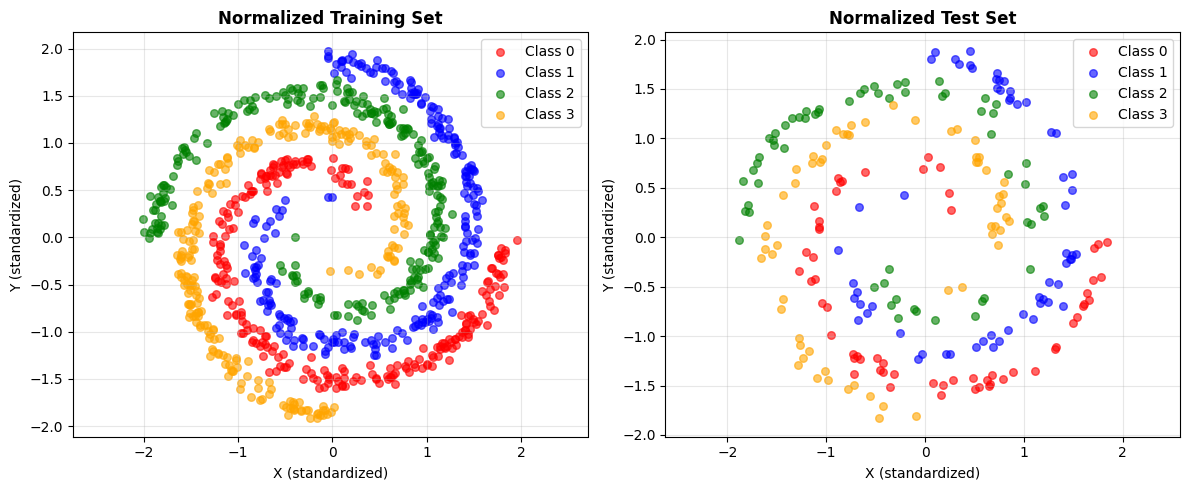

Training set - Mean: [0.000000, 0.000000]
Training set - Std: [1.000000, 1.000000]


In [8]:
# Visualize the normalized data
plt.figure(figsize=(12, 5))
colors = ['red', 'blue', 'green', 'orange']

# Plot 1: Normalized training data
plt.subplot(1, 2, 1)
for class_idx in range(num_classes):
    class_mask = y_train == class_idx
    plt.scatter(X_train_scaled[class_mask, 0], X_train_scaled[class_mask, 1],
                c=colors[class_idx], label=f'Class {class_idx}',
                alpha=0.6, s=30)
plt.title('Normalized Training Set', fontsize=12, fontweight='bold')
plt.xlabel('X (standardized)')
plt.ylabel('Y (standardized)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')

# Plot 2: Normalized test data
plt.subplot(1, 2, 2)
for class_idx in range(num_classes):
    class_mask = y_test == class_idx
    plt.scatter(X_test_scaled[class_mask, 0], X_test_scaled[class_mask, 1],
                c=colors[class_idx], label=f'Class {class_idx}',
                alpha=0.6, s=30)
plt.title('Normalized Test Set', fontsize=12, fontweight='bold')
plt.xlabel('X (standardized)')
plt.ylabel('Y (standardized)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')

plt.tight_layout()
plt.show()

print(f"Training set - Mean: [{X_train_scaled[:, 0].mean():.6f}, {X_train_scaled[:, 1].mean():.6f}]")
print(f"Training set - Std: [{X_train_scaled[:, 0].std():.6f}, {X_train_scaled[:, 1].std():.6f}]")

### Convert to PyTorch Tensors

Convert numpy arrays to PyTorch tensors:
- Features are converted to `float32` tensors
- Labels are converted to `long` (int64) tensors for classification
- Required format for PyTorch neural network training

In [9]:
# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_train_tensor = torch.LongTensor(y_train.astype(int))
y_test_tensor = torch.LongTensor(y_test.astype(int))

print(f"Tensor shapes:")
print(f"  X_train: {X_train_tensor.shape}, dtype: {X_train_tensor.dtype}")
print(f"  X_test: {X_test_tensor.shape}, dtype: {X_test_tensor.dtype}")
print(f"  y_train: {y_train_tensor.shape}, dtype: {y_train_tensor.dtype}")
print(f"  y_test: {y_test_tensor.shape}, dtype: {y_test_tensor.dtype}")

Tensor shapes:
  X_train: torch.Size([960, 2]), dtype: torch.float32
  X_test: torch.Size([240, 2]), dtype: torch.float32
  y_train: torch.Size([960]), dtype: torch.int64
  y_test: torch.Size([240]), dtype: torch.int64


### Create PyTorch Datasets

Wrap tensors in `TensorDataset` objects:
- Combines features and labels into a single dataset
- Enables easy batching and shuffling during training
- Separate datasets for training and testing

In [10]:
# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders for batch processing
batch_size = 32

train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True,  # Shuffle training data
    drop_last=False
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False,  # Don't shuffle test data
    drop_last=False
)

print(f"DataLoader configuration:")
print(f"  Batch size: {batch_size}")
print(f"  Number of training batches: {len(train_loader)}")
print(f"  Number of test batches: {len(test_loader)}")
print(f"\nData is ready for model training!")

DataLoader configuration:
  Batch size: 32
  Number of training batches: 30
  Number of test batches: 8

Data is ready for model training!


## TabNet Model Implementation

TabNet is a state-of-the-art deep learning architecture specifically designed for tabular data. It combines the power of neural networks with interpretability features.

### What is TabNet?

**TabNet** (Tabular Network) is a novel deep learning architecture introduced by Google Research in 2019, specifically designed for tabular data.

#### Key Features:

1. **Attention-Based Feature Selection**
   - Uses sequential attention mechanism to select relevant features at each decision step
   - Learns which features are important for each prediction
   - Mimics decision trees but in a differentiable way

2. **Instance-Wise Feature Selection**
   - Different features can be important for different samples
   - Provides sample-specific feature importance
   - Unlike traditional models that use the same features for all predictions

3. **Interpretability**
   - Built-in feature importance scores
   - Attention masks show which features were used for each prediction
   - Helps understand model decisions (crucial for machine unlearning)

4. **Self-Supervised Learning**
   - Can use unsupervised pre-training on unlabeled data
   - Improves performance when labeled data is limited

5. **Sparse Feature Selection**
   - Uses sparsemax instead of softmax for attention
   - Promotes sparse solutions (only a few features selected per step)
   - Reduces overfitting and improves efficiency

#### Architecture Components:

- **Feature Transformer**: Processes selected features through shared and decision-step-specific layers
- **Attentive Transformer**: Generates attention masks for feature selection
- **Decision Steps**: Multiple sequential steps that iteratively refine the prediction
- **Ghost Batch Normalization**: Stabilizes training with small batch sizes

#### Why TabNet for This Task?

1. **Tabular Data Excellence**: Our spiral dataset is tabular (X, Y coordinates)
2. **Interpretability**: Essential for understanding what features the model learns
3. **Non-linear Boundaries**: Can learn complex spiral patterns
4. **Feature Importance**: Helps identify what the model focuses on
5. **Machine Unlearning**: Interpretability aids in selective forgetting

#### TabNet vs Traditional Models:

| Aspect | TabNet | Traditional NN | Decision Trees |
|--------|--------|----------------|----------------|
| Interpretability | ✅ High | ❌ Low | ✅ High |
| Feature Selection | ✅ Automatic | ❌ Manual | ✅ Automatic |
| Tabular Data | ✅ Optimized | ⚠️ Requires tuning | ✅ Native |
| Non-linear | ✅ Yes | ✅ Yes | ⚠️ Limited |
| Scalability | ✅ Good | ✅ Excellent | ⚠️ Limited |

### Define TabNet Model Configuration

Configure the TabNet model with specific hyperparameters.

#### Key Hyperparameters Explained:

- **n_d, n_a** (8): Width of decision and attention layers
  - Controls model capacity
  - Typical range: 8-64
  - Higher = more capacity but slower training

- **n_steps** (3): Number of sequential attention steps
  - How many times the model refines its prediction
  - Range: 3-10
  - More steps = more interpretable but slower

- **gamma** (1.3): Coefficient for feature reuse penalty
  - Encourages using different features at each step
  - Range: 1.0-2.0
  - Higher = more feature diversity

- **lambda_sparse** (1e-3): Sparsity regularization
  - Encourages sparse attention (fewer features per step)
  - Improves interpretability

- **optimizer_params**: Learning rate and other optimizer settings
- **scheduler_params**: Learning rate decay schedule
- **mask_type** ('sparsemax'): Attention mechanism type
  - 'sparsemax': Sparse attention (recommended)
  - 'entmax': Adaptive sparse attention

In [12]:
# Define TabNet model
tabnet_model = TabNetClassifier(
    n_d=8,                    # Width of the decision prediction layer
    n_a=8,                    # Width of the attention embedding
    n_steps=3,                # Number of sequential decision steps
    gamma=1.3,                # Coefficient for feature reuse in attention
    cat_idxs=[],              # Indices of categorical features (none in our case)
    cat_dims=[],              # Dimensions of categorical features
    cat_emb_dim=1,            # Embedding dimension for categorical features
    n_independent=2,          # Number of independent GLU layers at each step
    n_shared=2,               # Number of shared GLU layers at each step
    epsilon=1e-15,            # Small value to avoid log(0)
    momentum=0.02,            # Momentum for batch normalization
    lambda_sparse=1e-3,       # Sparsity regularization parameter
    seed=42,                  # Random seed for reproducibility
    clip_value=1.0,           # Gradient clipping value
    verbose=1,                # Verbosity level
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    scheduler_params=dict(step_size=10, gamma=0.9),
    mask_type='sparsemax'     # Type of attention mechanism
)

print("TabNet model initialized successfully!")
print(f"Model architecture: {tabnet_model}")

TabNet model initialized successfully!
Model architecture: TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamma=1.3, cat_idxs=[], cat_dims=[], cat_emb_dim=[], n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.02, lambda_sparse=0.001, seed=42, clip_value=1.0, verbose=1, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=<class 'torch.optim.lr_scheduler.StepLR'>, scheduler_params={'step_size': 10, 'gamma': 0.9}, mask_type='sparsemax', input_dim=None, output_dim=None, device_name='auto', n_shared_decoder=1, n_indep_decoder=1, grouped_features=[])


/Users/eshaanmittal/Desktop/UB/TFG/Codes/venv/lib/python3.13/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


### Train TabNet Model

Train the TabNet model on the training data.

#### Training Parameters:

- **X_train, y_train**: Training features and labels
- **eval_set**: Validation set to monitor performance during training
- **eval_metric**: Metrics to track ('accuracy' in our case)
- **max_epochs** (200): Maximum number of training epochs
- **patience** (15): Early stopping patience (stops if no improvement)
- **batch_size** (256): Number of samples per batch
- **virtual_batch_size** (128): For Ghost Batch Normalization
- **num_workers** (0): Number of parallel data loading workers
- **drop_last** (False): Whether to drop the last incomplete batch

#### What Happens During Training:

1. **Forward Pass**: Data flows through attention steps
2. **Feature Selection**: Attention masks select relevant features
3. **Prediction**: Combined information makes final prediction
4. **Loss Calculation**: Cross-entropy loss for classification
5. **Backward Pass**: Gradients computed and parameters updated
6. **Validation**: Model evaluated on validation set
7. **Early Stopping**: Training stops if validation doesn't improve

The model will display training progress including loss and accuracy.

In [23]:
# Train the model
print("Starting TabNet training...")
print("=" * 60)

start_time = time.time()

tabnet_model.fit(
    X_train=X_train_scaled,
    y_train=y_train,
    eval_set=[(X_test_scaled, y_test)],
    eval_name=['test'],
    eval_metric=['accuracy'],
    max_epochs=200,
    patience=15,              # Early stopping patience
    batch_size=256,
    virtual_batch_size=128,   # For Ghost Batch Normalization
    num_workers=0,
    drop_last=False
)

training_time = time.time() - start_time

print("=" * 60)
print(f"Training completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")
print("Model trained successfully!")

Starting TabNet training...
epoch 0  | loss: 1.35532 | test_accuracy: 0.25833 |  0:00:00s
epoch 1  | loss: 1.0457  | test_accuracy: 0.38333 |  0:00:00s
epoch 2  | loss: 0.90004 | test_accuracy: 0.39167 |  0:00:00s
epoch 3  | loss: 0.81021 | test_accuracy: 0.40417 |  0:00:00s
epoch 4  | loss: 0.686   | test_accuracy: 0.42917 |  0:00:00s
epoch 5  | loss: 0.6257  | test_accuracy: 0.45417 |  0:00:00s
epoch 6  | loss: 0.57163 | test_accuracy: 0.525   |  0:00:00s
epoch 7  | loss: 0.53204 | test_accuracy: 0.50833 |  0:00:00s
epoch 8  | loss: 0.42188 | test_accuracy: 0.45833 |  0:00:00s
epoch 9  | loss: 0.38194 | test_accuracy: 0.56667 |  0:00:00s
epoch 10 | loss: 0.44068 | test_accuracy: 0.53333 |  0:00:00s
epoch 11 | loss: 0.33996 | test_accuracy: 0.67083 |  0:00:00s
epoch 12 | loss: 0.27684 | test_accuracy: 0.69167 |  0:00:00s
epoch 13 | loss: 0.28157 | test_accuracy: 0.6875  |  0:00:00s
epoch 14 | loss: 0.30733 | test_accuracy: 0.7875  |  0:00:00s
epoch 15 | loss: 0.26255 | test_accuracy: 

/Users/eshaanmittal/Desktop/UB/TFG/Codes/venv/lib/python3.13/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


### Evaluate TabNet Model Performance

Evaluate the trained model on both training and test sets.

#### Evaluation Metrics:

1. **Accuracy**: Percentage of correct predictions
2. **Confusion Matrix**: Shows true vs predicted classes
3. **Classification Report**: Precision, recall, F1-score per class
4. **Training vs Test Performance**: Checks for overfitting

#### What to Look For:

- **High accuracy**: Model learned the patterns well
- **Similar train/test accuracy**: No overfitting
- **Balanced per-class performance**: All spirals classified equally well
- **Diagonal confusion matrix**: Correct predictions on diagonal

In [14]:
# Make predictions
y_train_pred = tabnet_model.predict(X_train_scaled)
y_test_pred = tabnet_model.predict(X_test_scaled)

# Calculate accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("=" * 60)
print("TABNET MODEL PERFORMANCE")
print("=" * 60)
print(f"Training Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"Test Accuracy:     {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Overfitting Gap:   {abs(train_accuracy - test_accuracy):.4f}")
print("=" * 60)

# Confusion Matrix
print("\nConfusion Matrix (Test Set):")
cm = confusion_matrix(y_test, y_test_pred)
print(cm)

# Classification Report
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred, 
                          target_names=[f'Class {i}' for i in range(num_classes)]))

TABNET MODEL PERFORMANCE
Training Accuracy: 0.9885 (98.85%)
Test Accuracy:     0.9833 (98.33%)
Overfitting Gap:   0.0052

Confusion Matrix (Test Set):
[[59  0  0  1]
 [ 1 59  0  0]
 [ 0  0 59  1]
 [ 0  0  1 59]]

Classification Report (Test Set):
              precision    recall  f1-score   support

     Class 0       0.98      0.98      0.98        60
     Class 1       1.00      0.98      0.99        60
     Class 2       0.98      0.98      0.98        60
     Class 3       0.97      0.98      0.98        60

    accuracy                           0.98       240
   macro avg       0.98      0.98      0.98       240
weighted avg       0.98      0.98      0.98       240



### Visualize TabNet Predictions

Visualize the model's predictions on the test set to see how well it learned the spiral patterns.

The visualization shows:
- **Left plot**: True labels (ground truth)
- **Right plot**: Predicted labels
- **Colors**: Each class has a distinct color

A good model should have very similar-looking plots, indicating accurate predictions.

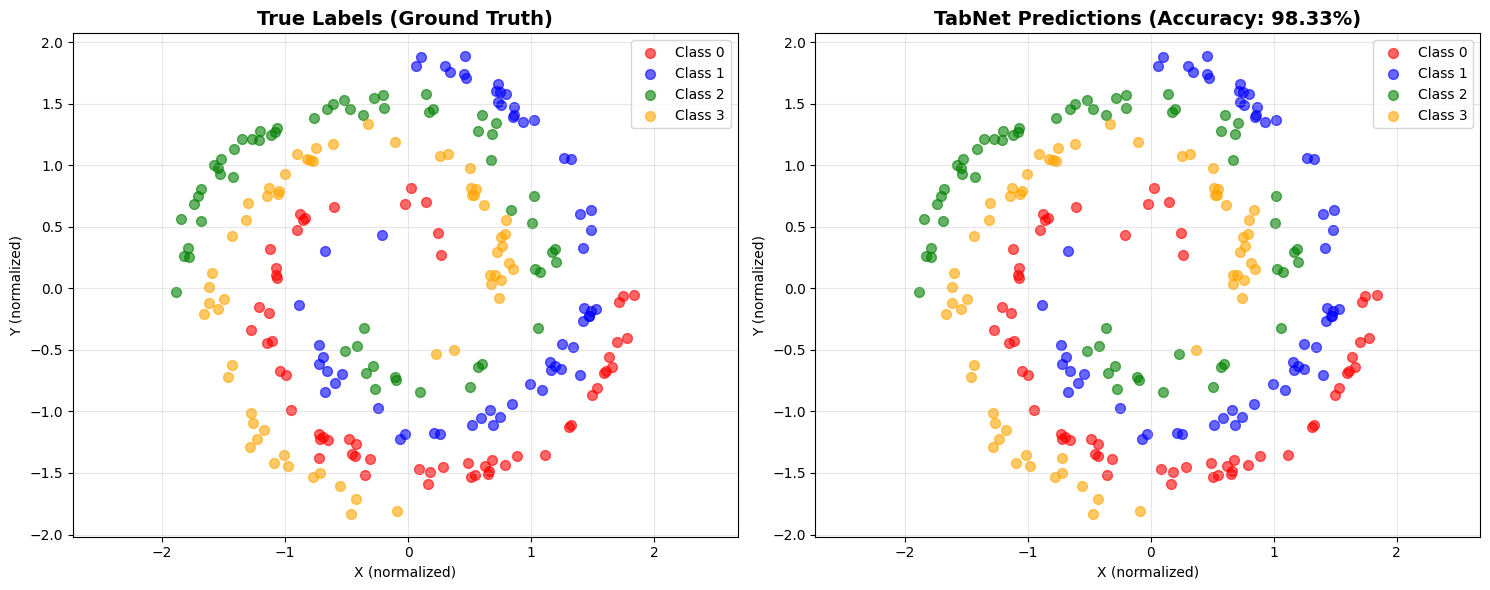


Number of misclassified samples: 4 out of 240
Misclassification rate: 1.67%


In [15]:
# Visualize predictions on test set
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
colors = ['red', 'blue', 'green', 'orange']

# Plot 1: True labels
for class_idx in range(num_classes):
    mask = y_test == class_idx
    axes[0].scatter(X_test_scaled[mask, 0], X_test_scaled[mask, 1],
                   c=colors[class_idx], label=f'Class {class_idx}',
                   alpha=0.6, s=50)
axes[0].set_title('True Labels (Ground Truth)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('X (normalized)')
axes[0].set_ylabel('Y (normalized)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].axis('equal')

# Plot 2: Predicted labels
for class_idx in range(num_classes):
    mask = y_test_pred == class_idx
    axes[1].scatter(X_test_scaled[mask, 0], X_test_scaled[mask, 1],
                   c=colors[class_idx], label=f'Class {class_idx}',
                   alpha=0.6, s=50)
axes[1].set_title(f'TabNet Predictions (Accuracy: {test_accuracy:.2%})', 
                 fontsize=14, fontweight='bold')
axes[1].set_xlabel('X (normalized)')
axes[1].set_ylabel('Y (normalized)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].axis('equal')

plt.tight_layout()
plt.show()

# Highlight misclassified points
misclassified = y_test != y_test_pred
print(f"\nNumber of misclassified samples: {misclassified.sum()} out of {len(y_test)}")
print(f"Misclassification rate: {misclassified.sum()/len(y_test)*100:.2f}%")

### TabNet Feature Importance

One of TabNet's key advantages is built-in feature importance!

#### What is Feature Importance?

Feature importance shows how much each feature (X and Y coordinates) contributed to the model's predictions.

#### How TabNet Computes It:

- Aggregates attention masks across all samples and decision steps
- Higher values = feature was selected more often
- Values sum to 1.0 (normalized)

#### For Our Spiral Dataset:

- Both X and Y coordinates should be important
- If balanced (~0.5 each), both features are equally used
- Helps understand what the model learned
- Crucial for machine unlearning (know what to forget)

FEATURE IMPORTANCE
X coordinate   : 0.4824 (48.24%)
Y coordinate   : 0.5176 (51.76%)


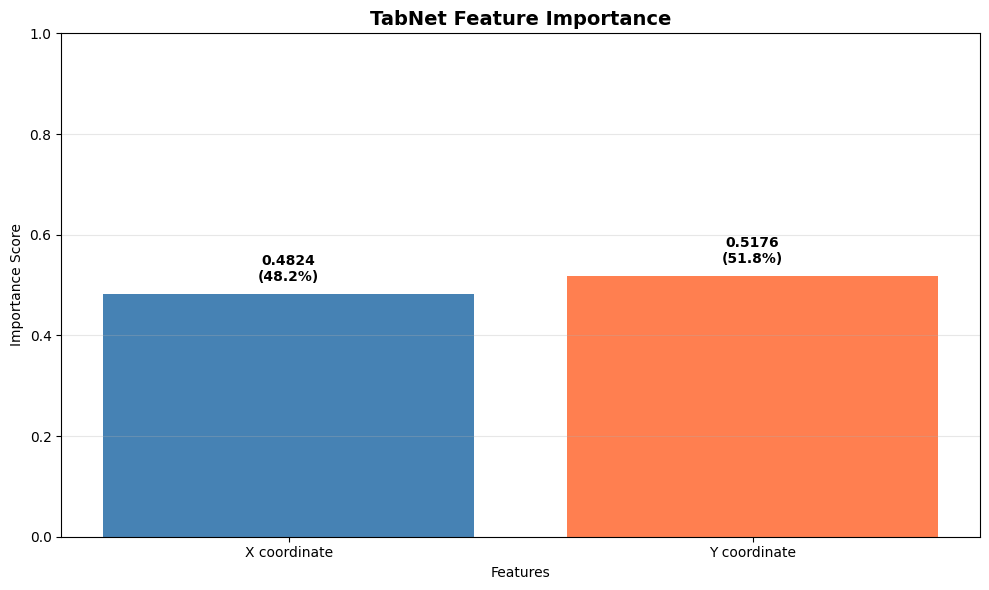


Interpretation:
Both features are equally important (balanced importance).
This makes sense for spiral patterns that use both X and Y symmetrically.


In [16]:
# Get feature importances
feature_importances = tabnet_model.feature_importances_

print("=" * 60)
print("FEATURE IMPORTANCE")
print("=" * 60)
feature_names = ['X coordinate', 'Y coordinate']
for name, importance in zip(feature_names, feature_importances):
    print(f"{name:15s}: {importance:.4f} ({importance*100:.2f}%)")
print("=" * 60)

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.bar(feature_names, feature_importances, color=['steelblue', 'coral'])
plt.title('TabNet Feature Importance', fontsize=14, fontweight='bold')
plt.ylabel('Importance Score')
plt.xlabel('Features')
plt.ylim(0, 1.0)
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (name, importance) in enumerate(zip(feature_names, feature_importances)):
    plt.text(i, importance + 0.02, f'{importance:.4f}\n({importance*100:.1f}%)',
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nInterpretation:")
if abs(feature_importances[0] - feature_importances[1]) < 0.1:
    print("Both features are equally important (balanced importance).")
    print("This makes sense for spiral patterns that use both X and Y symmetrically.")
else:
    dominant_feature = feature_names[feature_importances.argmax()]
    print(f"{dominant_feature} is more important for the predictions.")
    print("This suggests the model relies more on one coordinate than the other.")

### Save TabNet Model

Save the trained model for:
- Later use without retraining
- Machine unlearning experiments
- Deployment

The model is saved as a compressed zip file containing:
- Model weights
- Architecture configuration
- Training history

In [ ]:
# Save the model
#model_path = 'tabnet_spiral_model'
#tabnet_model.save_model(model_path)
#print(f"Model saved to: {model_path}")
#print("\nTo load the model later, use:")
#print("loaded_model = TabNetClassifier()")
#print(f"loaded_model.load_model('{model_path}')")

Successfully saved model at tabnet_spiral_model.zip
Model saved to: tabnet_spiral_model

To load the model later, use:
loaded_model = TabNetClassifier()
loaded_model.load_model('tabnet_spiral_model')
